In [ ]:
import pandas as pd

train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# Keeping track on which dataset is which
train_df["is_train"] = 1
test_df["is_train"] = 0

# Merging the datasets into one for easier processing
df = pd.concat([train_df, test_df], ignore_index=True)

# Converting performance ratings into numbers for analysis
rating_map = {'Low': 1, 'Below Average': 2, 'Average': 3, 'High': 4}
df['Performance Rating'] = df['Performance Rating'].map(rating_map)

# Dropping 'Employee ID' and missing values
df = df.drop(columns=['Employee ID']).dropna()

# Turning Work-Life Balance and Job Satisfaction into ordered numbers
wlb_map = {'Poor': 1, 'Fair': 2, 'Good': 3}
js_map = {'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
df['WLB_Ordinal'] = df['Work-Life Balance'].map(wlb_map)
df['JobSatisfaction_Ordinal'] = df['Job Satisfaction'].map(js_map)

# Creating new features to capture relationships in the data
df['IncomePerYear'] = df['Monthly Income'] / (df['Years at Company'] + 1)
df['IncomePerDependent'] = df['Monthly Income'] / (df['Number of Dependents'] + 1)
df['Overtime_and_Remote'] = ((df['Overtime'] == 'Yes') & (df['Remote Work'] == 'Yes')).astype(int)
df['Satisfaction_Interaction'] = df['WLB_Ordinal'] * df['JobSatisfaction_Ordinal']

# Grouping commute distances into short, medium, and long categories
bins = [0, 5, 15, df['Distance from Home'].max() + 1]
labels = ['Short', 'Medium', 'Long']
df['DistanceBin'] = pd.cut(df['Distance from Home'], bins=bins, labels=labels)

# Dropping original WLB/Satisfaction columns since they have been encoded
df.drop(columns=['Work-Life Balance', 'Job Satisfaction'], inplace=True)

# Converting categorical features like Job Role and Marital Status into dummy variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Splitting the data into train/test sets
train_df_encoded = df_encoded[df_encoded["is_train"] == 1].drop(columns=["is_train"])
test_df_encoded = df_encoded[df_encoded["is_train"] == 0].drop(columns=["is_train"])

print("Train shape:", train_df_encoded.shape)
print("Test shape:", test_df_encoded.shape)


Train shape: (59598, 42)
Test shape: (14900, 42)


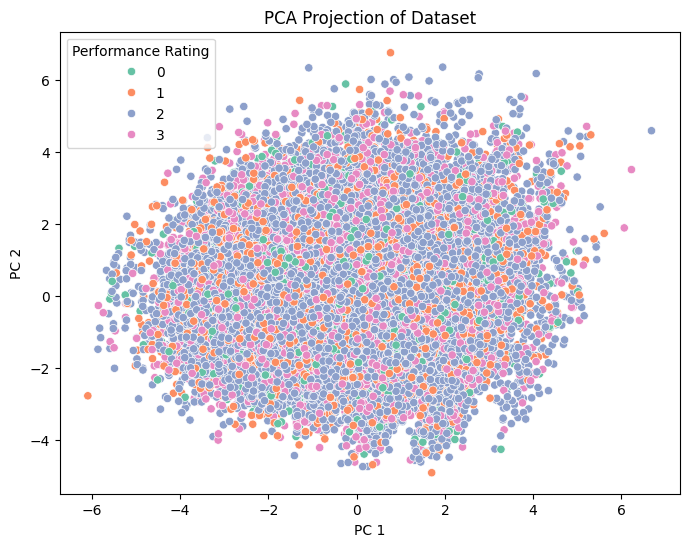

<ipython-input-10-6d8b59bbc8a6>:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x="Importance", y="Feature", palette="viridis")


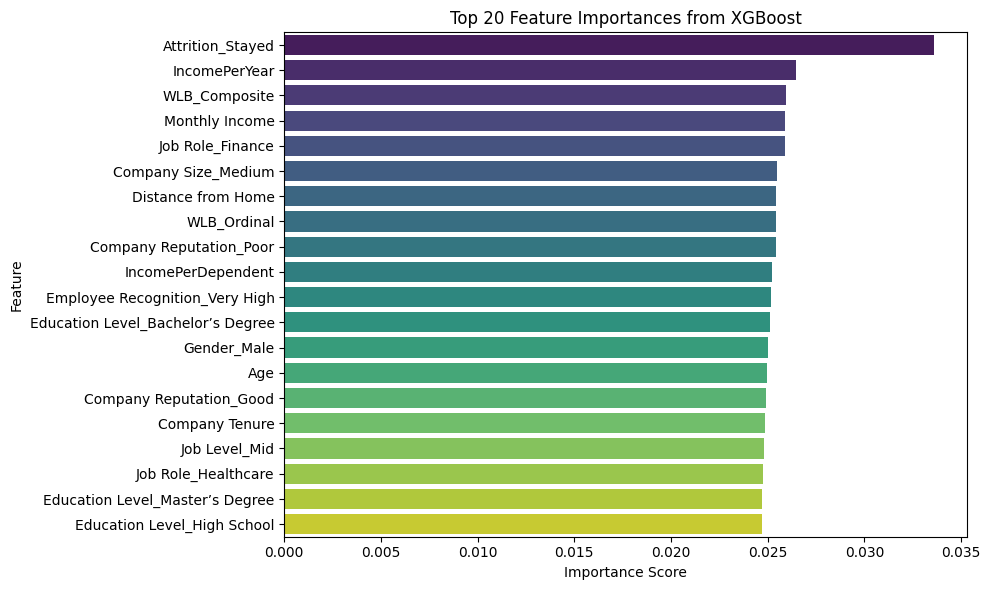

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# Adding an identifier to tell datasets apart and combining them for preprocessing
train_df["is_train"] = 1
test_df["is_train"] = 0
df = pd.concat([train_df, test_df], ignore_index=True)

# Turning performance ratings into numbers
rating_map = {'Low': 1, 'Below Average': 2, 'Average': 3, 'High': 4}
df["Performance Rating"] = df["Performance Rating"].map(rating_map)

# Dropping 'Employee ID' column
df.drop(columns=["Employee ID"], inplace=True)

# Converting Work-Life Balance and Job Satisfaction to ordered numbers
df["WLB_Ordinal"] = df["Work-Life Balance"].map({'Poor': 1, 'Fair': 2, 'Good': 3})
df["JobSatisfaction_Ordinal"] = df["Job Satisfaction"].map({'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4})

# Creating new features to build a Work-Life Balance score
wlb_features = ['WLB_Ordinal', 'JobSatisfaction_Ordinal', 'Monthly Income',
                'Years at Company', 'Number of Dependents', 'Overtime',
                'Distance from Home', 'Remote Work']
df['IncomePerYear'] = df['Monthly Income'] / (df['Years at Company'] + 1)
df['IncomePerDependent'] = df['Monthly Income'] / (df['Number of Dependents'] + 1)
df['Overtime_and_Remote'] = ((df['Overtime'] == 'Yes') & (df['Remote Work'] == 'Yes')).astype(int)
df['Satisfaction_Interaction'] = df['WLB_Ordinal'] * df['JobSatisfaction_Ordinal']

# Group commute distances into short, medium, and long - binning distance
bins = [0, 5, 15, df['Distance from Home'].max()+1]
labels = ['Short', 'Medium', 'Long']
df['DistanceBin'] = pd.cut(df['Distance from Home'], bins=bins, labels=labels)
df['DistanceBin_Encoded'] = df['DistanceBin'].map({'Short': 1, 'Medium': 2, 'Long': 3})

# WLB Composite Score
wlb_comp_features = ['WLB_Ordinal', 'JobSatisfaction_Ordinal', 'IncomePerYear',
                     'IncomePerDependent', 'Overtime_and_Remote',
                     'Satisfaction_Interaction', 'DistanceBin_Encoded']
scaler = MinMaxScaler()
df["WLB_Composite"] = scaler.fit_transform(df[wlb_comp_features]).mean(axis=1)

# Dropping old WLB columns
df.drop(columns=["Work-Life Balance", "Job Satisfaction", "DistanceBin"], inplace=True)

# Converting categorical variables into dummy variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Splitting back into train/test set
train_df_encoded = df_encoded[df_encoded["is_train"] == 1].drop(columns=["is_train"])
test_df_encoded = df_encoded[df_encoded["is_train"] == 0].drop(columns=["is_train"])

# Separating features and target for modeling
X = train_df_encoded.drop(columns=["Performance Rating"])
y = train_df_encoded["Performance Rating"] - 1  # 0-3 labels

# Dropping NaNs
X = X.dropna()
y = y[X.index]

# ===== PCA =====
# Standardizing the features for PCA
scaler_std = StandardScaler()
X_scaled = scaler_std.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set2')
plt.title("PCA Projection of Dataset")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

# ===== Model-Based Feature Importance (XGBoost) =====
# Training an XGBoost model to see which features matter most
model = XGBClassifier(random_state=42)
model.fit(X_scaled, y)

importances = model.feature_importances_
feat_names = X.columns
feat_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_df = feat_df.sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df, x="Importance", y="Feature", palette="viridis")
plt.title("Top 20 Feature Importances from XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway
import seaborn as sns
import matplotlib.pyplot as plt

# Mapping DistanceBin to numeric
df['DistanceBin_Encoded'] = df['DistanceBin'].map({'Short': 1, 'Medium': 2, 'Long': 3})

# WLB features (with encoded distance)
wlb_features = [
    'WLB_Ordinal',
    'JobSatisfaction_Ordinal',
    'IncomePerYear',
    'IncomePerDependent',
    'Overtime_and_Remote',
    'Satisfaction_Interaction',
    'DistanceBin_Encoded'
]

# Normalizing and creating WLB Composite Score
scaler = MinMaxScaler()
df['WLB_Composite'] = pd.DataFrame(scaler.fit_transform(df[wlb_features]), columns=wlb_features).mean(axis=1)

# ANOVA test across performance groups
groups = [df[df['Performance Rating'] == rating]['WLB_Composite'] for rating in sorted(df['Performance Rating'].unique())]
f_stat, p_val = f_oneway(*groups)

print("🔎 ANOVA Test for WLB Composite Score vs. Performance Rating")
print(f"F-Statistic: {f_stat:.4f}")
print(f"P-Value: {p_val:.4f}")

# Step 6: Visualize
sns.boxplot(x='Performance Rating', y='WLB_Composite', data=df)
plt.title('WLB Composite Score by Performance Rating')
plt.xlabel('Performance Rating')
plt.ylabel('Composite WLB Score')
plt.show()


KeyError: 'DistanceBin'

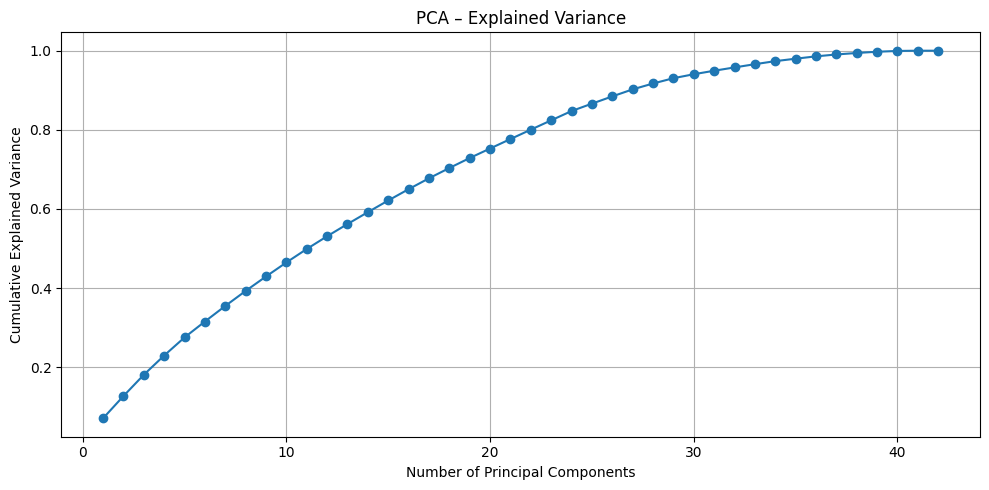

<ipython-input-5-60ee702b1e75>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_df.head(20), x='Importance', y='Feature', palette='crest')


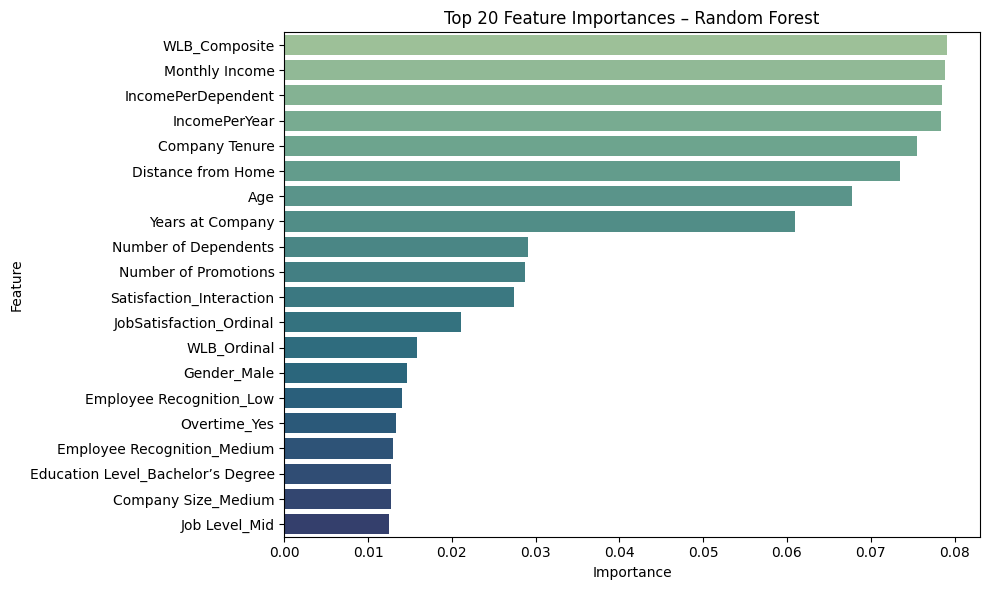

,Feature,Importance
13,WLB_Composite,0.079084
2,Monthly Income,0.078817
10,IncomePerDependent,0.078447
9,IncomePerYear,0.078339
6,Company Tenure,0.075539
4,Distance from Home,0.073487
0,Age,0.067770
1,Years at Company,0.060946
5,Number of Dependents,0.029087
3,Number of Promotions,0.028685


In [ ]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Setting up our features and target for modeling
X = train_df_encoded.drop(columns=["Performance Rating"])
y = train_df_encoded["Performance Rating"] - 1  # labels to 0–3

# Dropping NaNs
X = X.dropna()
y = y[X.index]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA used to reduce dimensionality
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot Cumulative Explained Variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA – Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

# Random Forest Feature Importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y)

importances = rf.feature_importances_
feature_names = X.columns

# Creating DataFrame
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot Top 20 Features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_df.head(20), x='Importance', y='Feature', palette='crest')
plt.title("Top 20 Feature Importances – Random Forest")
plt.tight_layout()
plt.show()

feature_df.head(20)


In [ ]:
!pip install mord

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=7b92a82b13af0519eddb2cc531db3646274800df74ba1fec0ad495d70b1436f3
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


<ipython-input-11-e88a3e2c252d>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(20), y='Feature', x='Coefficient', palette='crest')


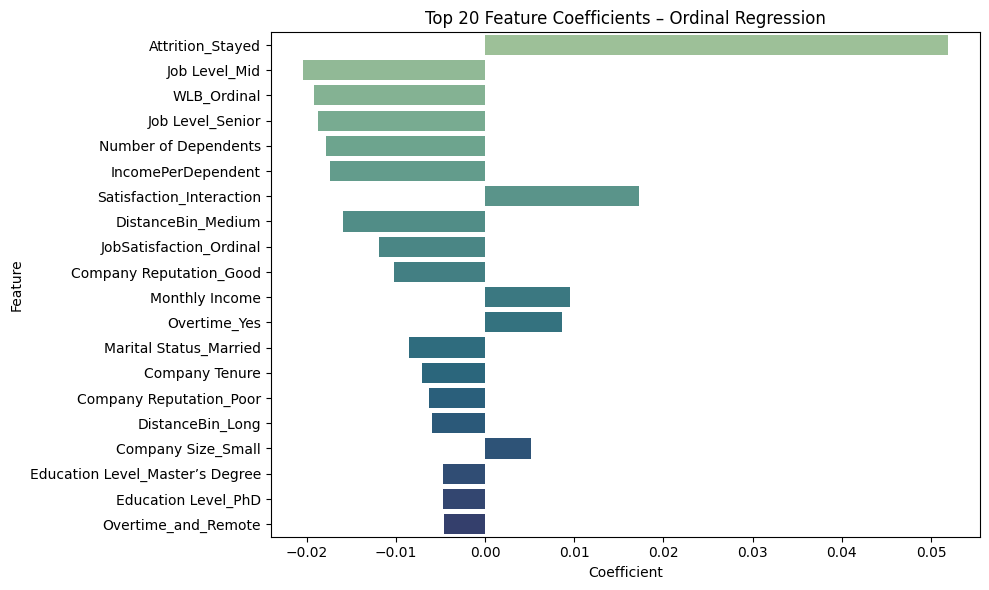

In [ ]:
from mord import OrdinalRidge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Setting up our features and target for modeling
X = train_df_encoded.drop(columns=["Performance Rating"])
y = train_df_encoded["Performance Rating"]

# Splitting data into training an testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Dropping NaNs from training set only
train_na_free = pd.concat([X_train, y_train], axis=1).dropna()
X_train_clean = train_na_free.drop(columns=["Performance Rating"])
y_train_clean = train_na_free["Performance Rating"]

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)

# Training an Ordinal Ridge model for performance ratings
ord_model = OrdinalRidge()
ord_model.fit(X_train_scaled, y_train_clean)

# Checking which features are driving predictions by looking at their coefficients
feature_importance_df = pd.DataFrame({
    'Feature': X_train_clean.columns,
    'Coefficient': ord_model.coef_.flatten()
}).sort_values(by='Coefficient', key=abs, ascending=False) # Sort by absolute value to see biggest impacts

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(20), y='Feature', x='Coefficient', palette='crest')
plt.title("Top 20 Feature Coefficients – Ordinal Regression")
plt.tight_layout()
plt.show()


📊 One-Way ANOVA Results (WLB → Job Satisfaction)

WLB_Ordinal: F = nan, p = nan
IncomePerYear: F = 0.0949, p = 0.9629
IncomePerDependent: F = 1.3119, p = 0.2685
Overtime_and_Remote: F = 2.4448, p = 0.0620
Satisfaction_Interaction: F = nan, p = nan
DistanceBin_Encoded: F = 0.6244, p = 0.5992
WLB_Composite: F = nan, p = nan

📈 Spearman Correlation (WLB features vs. Job Satisfaction)

WLB_Ordinal: Spearman r = -0.0022, p = 0.5852
IncomePerYear: Spearman r = -0.0024, p = 0.5198
IncomePerDependent: Spearman r = -0.0079, p = 0.0320
Overtime_and_Remote: Spearman r = 0.0002, p = 0.9562
Satisfaction_Interaction: Spearman r = 0.6361, p = 0.0000
DistanceBin_Encoded: Spearman r = 0.0006, p = 0.8771
WLB_Composite: Spearman r = 0.5378, p = 0.0000


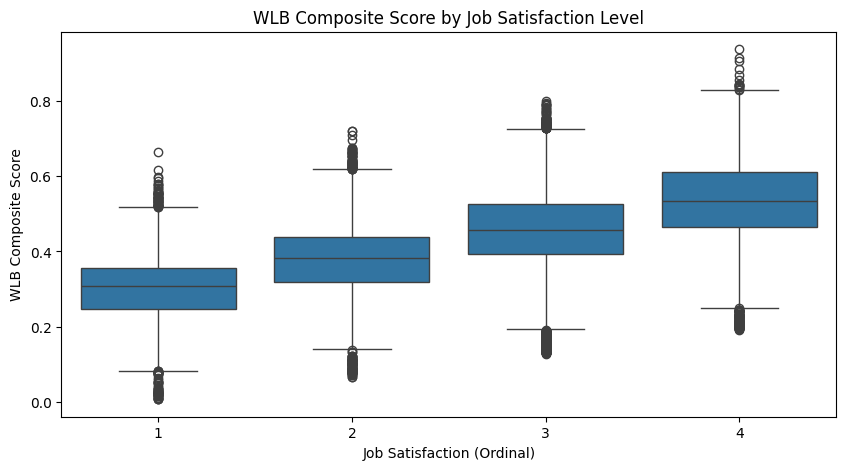

In [ ]:
import pandas as pd
from scipy.stats import f_oneway, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting relevant features related to Work-Life Balance (WLB)
wlb_related_features = [
    'WLB_Ordinal',
    'IncomePerYear',
    'IncomePerDependent',
    'Overtime_and_Remote',
    'Satisfaction_Interaction',
    'DistanceBin_Encoded',
    'WLB_Composite'
]

# One-Way ANOVA Analysis
# https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide.php
# Tests whether there are significant differences in WLB features across job satisfaction levels
print("One-Way ANOVA Results (WLB → Job Satisfaction)\n")
for feature in wlb_related_features:
    # Create groups for each job satisfaction level
    groups = [df[df['JobSatisfaction_Ordinal'] == level][feature]
              for level in sorted(df['JobSatisfaction_Ordinal'].dropna().unique())]
    # Perform ANOVA test
    f_stat, p_val = f_oneway(*groups)
    print(f"{feature}: F = {f_stat:.4f}, p = {p_val:.4f}")


# Spearman Correlation -  Measures monotonic relationships between WLB features and job satisfaction
# https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide.php
print("\nSpearman Correlation (WLB features vs. Job Satisfaction)\n")
for feature in wlb_related_features:
    corr, p = spearmanr(df[feature], df['JobSatisfaction_Ordinal'], nan_policy='omit')
    print(f"{feature}: Spearman r = {corr:.4f}, p = {p:.4f}")

# Boxplot visualization
plt.figure(figsize=(10, 5))
sns.boxplot(x='JobSatisfaction_Ordinal', y='WLB_Composite', data=df)
plt.title('WLB Composite Score by Job Satisfaction Level')
plt.xlabel('Job Satisfaction (Ordinal)')
plt.ylabel('WLB Composite Score')
plt.show()


In [ ]:
from scipy.stats import kruskal

# Group performance by each job satisfaction level
groups = [df[df['JobSatisfaction_Ordinal'] == level]['Performance Rating']
          for level in sorted(df['JobSatisfaction_Ordinal'].unique())]

# Running Kruskal-Wallis test
# https://datatab.net/tutorial/kruskal-wallis-test
stat, p = kruskal(*groups)

print("🔍 Kruskal-Wallis H-Test:")
print(f"H-statistic: {stat:.4f}")
print(f"P-value: {p:.4f}")


🔍 Kruskal-Wallis H-Test:
H-statistic: 0.4597
P-value: 0.9277


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:42:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:

              precision    recall  f1-score   support

           1       0.04      0.18      0.07       746
           2       0.16      0.11      0.13      2228
           3       0.60      0.20      0.29      8944
           4       0.20      0.49      0.28      2982

    accuracy                           0.24     14900
   macro avg       0.25      0.24      0.19     14900
weighted avg       0.42      0.24      0.26     14900



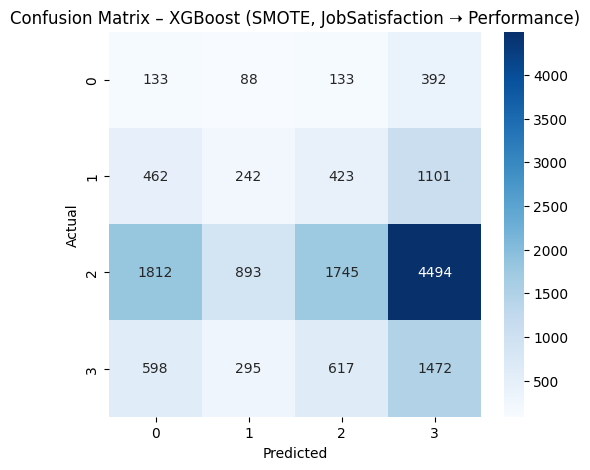

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Defining feature and target
X = df_encoded[['JobSatisfaction_Ordinal']]
y = df_encoded['Performance Rating'] - 1  # Convert to 0–3

# Splitting dataset into test and train sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE on training data to handle imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# XGBoost Model Training
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_train_res, y_train_res)

# Predictions
y_pred = model.predict(X_test)

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test + 1, y_pred + 1))  # back to 1–4 scale

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test + 1, y_pred + 1), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – XGBoost (SMOTE, JobSatisfaction ➝ Performance)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           1       0.05      0.70      0.09       885
           2       0.00      0.00      0.00      2685
           3       0.00      0.00      0.00     10743
           4       0.20      0.29      0.23      3567

    accuracy                           0.09     17880
   macro avg       0.06      0.25      0.08     17880
weighted avg       0.04      0.09      0.05     17880



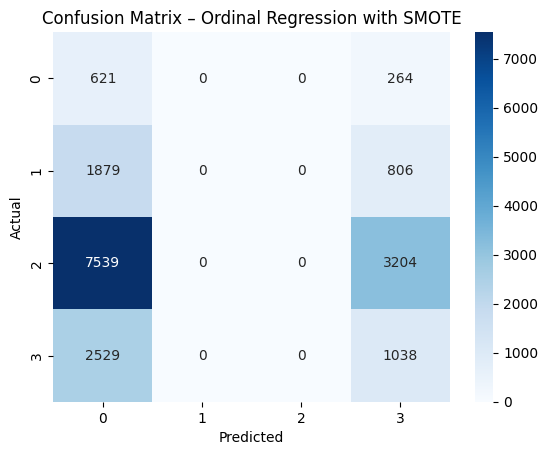

In [ ]:
# Install first if needed:
# pip install imblearn mord

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from mord import LogisticIT
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv").dropna()

# Encode target and feature - converting text performance ratings to numerical (1-4 scale)
df["Performance Rating"] = df["Performance Rating"].map({'Low': 1, 'Below Average': 2, 'Average': 3, 'High': 4})  # Make it 0–3
df["JobSatisfaction_Ordinal"] = df["Job Satisfaction"].map({'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4})

# Defining features X and y
X = df[["JobSatisfaction_Ordinal"]]
y = df["Performance Rating"]

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Applying SMOTE to handle imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Training Ordinal Logistic Regression
model = LogisticIT()
model.fit(X_train_res, y_train_res)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Ordinal Regression with SMOTE")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


📊 Classification Report – XGBoost (Multivariate)
              precision    recall  f1-score   support

           1       0.05      0.23      0.08       487
           2       0.16      0.21      0.18      1477
           3       0.59      0.39      0.47      5788
           4       0.19      0.16      0.17      1953

    accuracy                           0.31      9705
   macro avg       0.25      0.25      0.23      9705
weighted avg       0.42      0.31      0.35      9705

Accuracy: 0.310252447192169


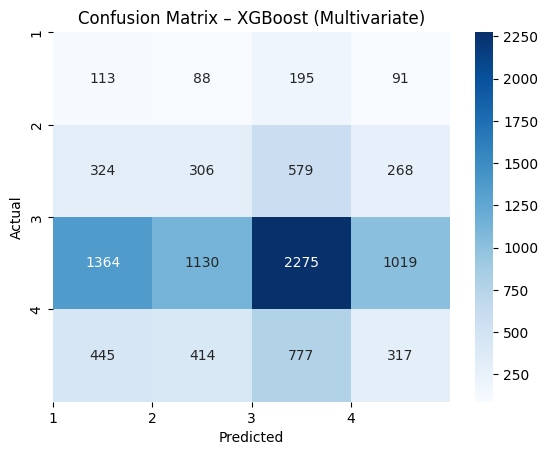

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# Split features and target
X = train_df_encoded[['JobSatisfaction_Ordinal', 'WLB_Composite', 'IncomePerYear', 'Overtime_and_Remote']]  # example custom selection
y = train_df_encoded["Performance Rating"] - 1  # convert 1–4 → 0–3

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Dropping rows with missing values (just to be safe)
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

# Applying SMOTE to training set for handling imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Training XGBoost model
model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
model.fit(X_train_scaled, y_train_resampled)

# Predict & Evaluate
y_pred = model.predict(X_test_scaled)
y_test_actual = y_test + 1
y_pred_actual = y_pred + 1

print("Classification Report – XGBoost (Multivariate)")
print(classification_report(y_test_actual, y_pred_actual))
print("Accuracy:", accuracy_score(y_test_actual, y_pred_actual))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_actual, y_pred_actual), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – XGBoost (Multivariate)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0,1,2,3], labels=[1,2,3,4])
plt.yticks(ticks=[0,1,2,3], labels=[1,2,3,4])
plt.show()


🔢 Class Distribution:
Performance Rating
1     2950
2     8950
3    35810
4    11888
Name: count, dtype: int64


<ipython-input-18-9c8f72602523>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='Set2')


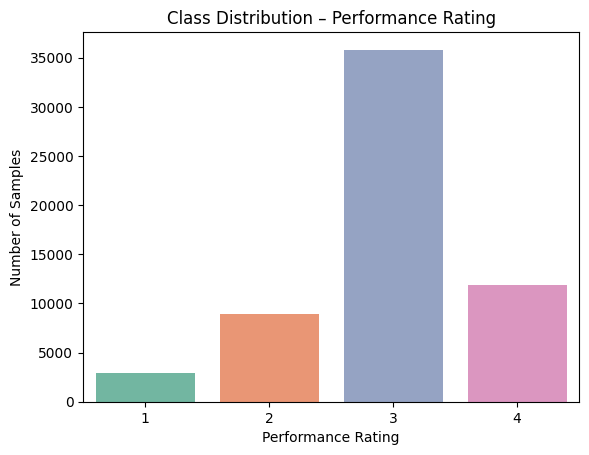

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


target_column = 'Performance Rating'
df = train_df_encoded

# Value counts
class_counts = df[target_column].value_counts().sort_index()
print("Class Distribution:")
print(class_counts)

# Bar plot
sns.barplot(x=class_counts.index, y=class_counts.values, palette='Set2')
plt.title("Class Distribution – Performance Rating")
plt.xlabel("Performance Rating")
plt.ylabel("Number of Samples")
plt.show()


📊 ANOVA Test for WLB Composite vs. Performance Rating
F-Statistic: nan
P-Value: nan


<ipython-input-13-12cf3998740f>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Performance Rating', y='WLB_Composite', data=df, palette='Blues')


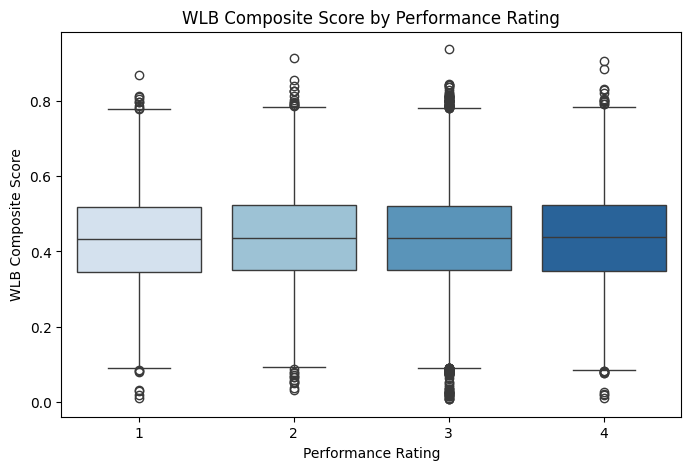

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

# Adding identifier flags before merging to keep track of datasets
train['is_train'] = 1
test['is_train'] = 0

# Combining datasets for preprocessing
df = pd.concat([train, test], ignore_index=True)

# Converting categorical performance ratings to numerical (1-4 scale)
rating_map = {'Low': 1, 'Below Average': 2, 'Average': 3, 'High': 4}
df['Performance Rating'] = df['Performance Rating'].map(rating_map)

# Dropping Employee ID + handle missing
df.drop(columns=['Employee ID'], inplace=True)
df.dropna(inplace=True)

# Ordinal mappings
df['WLB_Ordinal'] = df['Work-Life Balance'].map({'Poor': 1, 'Fair': 2, 'Good': 3})
df['JobSatisfaction_Ordinal'] = df['Job Satisfaction'].map({'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4})

# Interaction & ratio features
df['IncomePerYear'] = df['Monthly Income'] / (df['Years at Company'] + 1)
df['IncomePerDependent'] = df['Monthly Income'] / (df['Number of Dependents'] + 1)
df['Overtime_and_Remote'] = ((df['Overtime'] == 'Yes') & (df['Remote Work'] == 'Yes')).astype(int)
df['Satisfaction_Interaction'] = df['WLB_Ordinal'] * df['JobSatisfaction_Ordinal']

# Encode DistanceBin
bins = [0, 5, 15, df['Distance from Home'].max()+1]
labels = ['Short', 'Medium', 'Long']
df['DistanceBin'] = pd.cut(df['Distance from Home'], bins=bins, labels=labels)
df['DistanceBin_Encoded'] = df['DistanceBin'].map({'Short': 1, 'Medium': 2, 'Long': 3})

# Final WLB features for composite
wlb_features = [
    'WLB_Ordinal',
    'JobSatisfaction_Ordinal',
    'IncomePerYear',
    'IncomePerDependent',
    'Overtime_and_Remote',
    'Satisfaction_Interaction',
    'DistanceBin_Encoded'
]

# Scale and created composite
scaler = MinMaxScaler()
df['WLB_Composite'] = scaler.fit_transform(df[wlb_features]).mean(axis=1)

# ANOVA: group by performance
groups = [df[df['Performance Rating'] == i]['WLB_Composite'] for i in sorted(df['Performance Rating'].unique())]
f_stat, p_val = f_oneway(*groups)

# Output ANOVA results
print("ANOVA Test for WLB Composite vs. Performance Rating")
print(f"F-Statistic: {f_stat:.4f}")
print(f"P-Value: {p_val:.4f}")

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='Performance Rating', y='WLB_Composite', data=df, palette='Blues')
plt.title("WLB Composite Score by Performance Rating")
plt.xlabel("Performance Rating")
plt.ylabel("WLB Composite Score")
plt.show()


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Ensuring Work-Life Balance is mapped properly
wlb_map = {'Poor': 1, 'Fair': 2, 'Good': 3, 'Excellent': 4}
df['WLB_Ordinal'] = df['Work-Life Balance'].map(wlb_map)

# Dropping rows with NaNs in either column
df_chi = df.dropna(subset=['WLB_Ordinal', 'Performance Rating'])

# Creating contingency table
contingency_table = pd.crosstab(df_chi['WLB_Ordinal'], df_chi['Performance Rating'])

# Performing chi-square test
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2)
print("P-Value:", p_val)


Chi-Square Statistic: 10.87130643042798
P-Value: 0.2846335247827027


<ipython-input-14-c9f5990ac813>:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


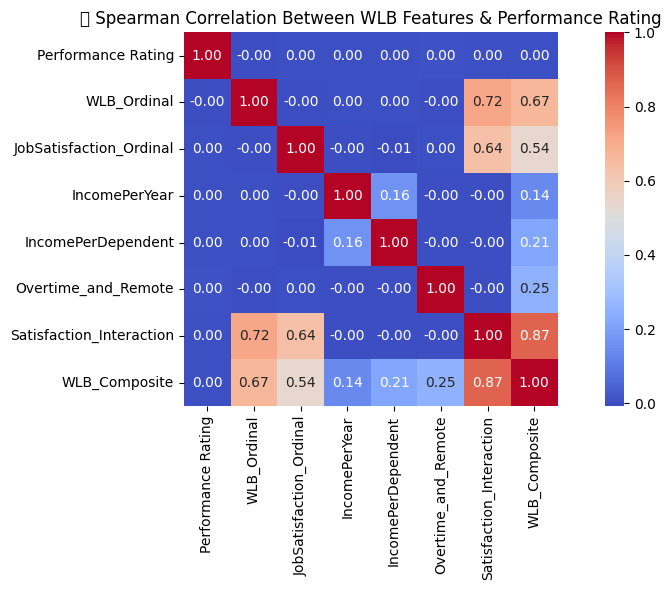

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# List of WLB-related features and target
wlb_corr_features = [
    'Performance Rating',
    'WLB_Ordinal',
    'JobSatisfaction_Ordinal',
    'IncomePerYear',
    'IncomePerDependent',
    'Overtime_and_Remote',
    'Satisfaction_Interaction',
    'WLB_Composite'
]

# Subset dataframe
wlb_corr_df = df[wlb_corr_features]

# Compute Spearman correlation
correlation_matrix = wlb_corr_df.corr(method='spearman')

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("📊 Spearman Correlation Between WLB Features & Performance Rating")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Manually calculating eta-squared from ANOVA
ss_between = sum([len(g) * (g.mean() - df['WLB_Composite'].mean())**2 for g in groups])
ss_total = sum((df['WLB_Composite'] - df['WLB_Composite'].mean())**2)
eta_squared = ss_between / ss_total

print(f"η² (Eta-Squared): {eta_squared:.4f}")


η² (Eta-Squared): 0.0001


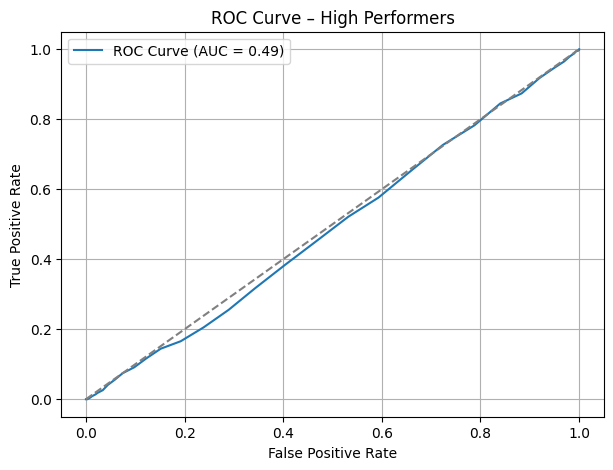

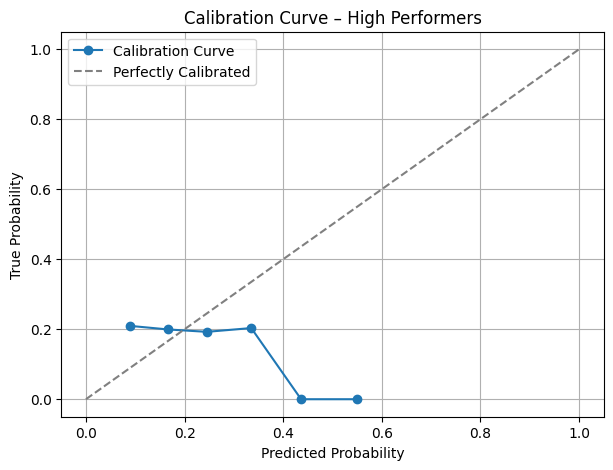

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Created a binary target variable
df_binary = df.copy()
df_binary['High_Performer'] = (df_binary['Performance Rating'] == 4).astype(int)

# Dropping old target
df_binary.drop(columns=['Performance Rating'], inplace=True)

# Defining X and y, features and target
X = df_binary.drop(columns=['High_Performer'])
y = df_binary['High_Performer']

# Encode all categorical columns
X = pd.get_dummies(X, drop_first=True)

# Drop NaNs (to ensure model stability)
X = X.dropna()
y = y.loc[X.index]

# Split data into training (75%) and test (25%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Standardize features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

# Probabilities for ROC & Calibration
y_probs = clf.predict_proba(X_test_scaled)[:, 1]  # probability of being class 1 (High Performer)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – High Performers")
plt.legend()
plt.grid(True)
plt.show()

# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)

plt.figure(figsize=(7,5))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve – High Performers")
plt.legend()
plt.grid(True)
plt.show()


🔍 ANOVA Test for Monthly Income vs. Performance Rating
F-Statistic: 0.9627
P-Value: 0.4092


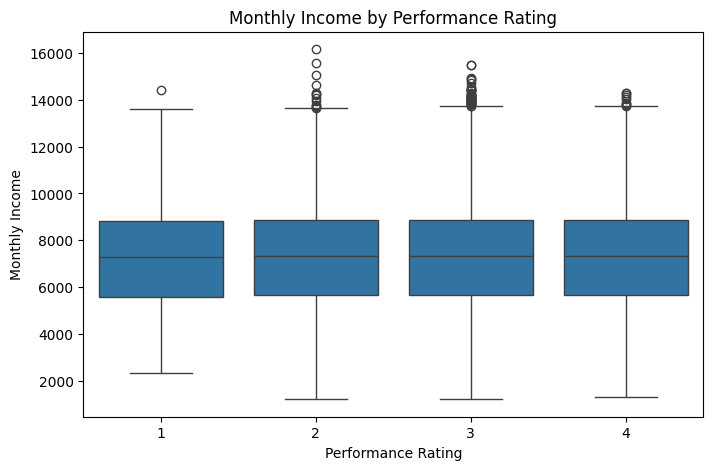

In [ ]:
import pandas as pd
from scipy.stats import f_oneway
import seaborn as sns
import matplotlib.pyplot as plt

# ANOVA: Test if mean income differs significantly across performance groups
groups_income = [df[df['Performance Rating'] == rating]['Monthly Income'] for rating in sorted(df['Performance Rating'].unique())]
f_stat_income, p_val_income = f_oneway(*groups_income)

print("🔍 ANOVA Test for Monthly Income vs. Performance Rating")
print(f"F-Statistic: {f_stat_income:.4f}")
print(f"P-Value: {p_val_income:.4f}")

# Visualization: Box plot to show income distribution across ratings
plt.figure(figsize=(8, 5))
sns.boxplot(x='Performance Rating', y='Monthly Income', data=df)
plt.title('Monthly Income by Performance Rating')
plt.xlabel('Performance Rating')
plt.ylabel('Monthly Income')
plt.show()


In [ ]:
from scipy.stats import f_oneway

# Selecting all numerical columns
numerical_cols = df.select_dtypes(include='number').columns
numerical_cols = [col for col in numerical_cols if col != 'Performance Rating']  # exclude target

anova_results = []

# ANOVA testing
for col in numerical_cols:
    groups = [df[df['Performance Rating'] == rating][col].dropna() for rating in sorted(df['Performance Rating'].unique())]
    if len(groups) > 1:  # make sure we have at least two groups
        f_stat, p_val = f_oneway(*groups)
        anova_results.append((col, f_stat, p_val))

# Sort by F-statistic (higher means more difference between groups)
anova_df = pd.DataFrame(anova_results, columns=["Feature", "F-Statistic", "P-Value"])
anova_df = anova_df.sort_values(by="F-Statistic", ascending=False)

print(anova_df)


                     Feature  F-Statistic   P-Value
5       Number of Dependents     2.222216  0.083326
14             WLB_Composite     1.926289  0.122889
8                WLB_Ordinal     1.872634  0.131766
12       Overtime_and_Remote     1.258856  0.286632
11        IncomePerDependent     1.253817  0.288410
7                   is_train     1.207177  0.305347
3       Number of Promotions     1.138356  0.331953
4         Distance from Home     1.056246  0.366340
2             Monthly Income     0.962677  0.409219
9    JobSatisfaction_Ordinal     0.653563  0.580609
6             Company Tenure     0.543575  0.652445
13  Satisfaction_Interaction     0.406514  0.748322
10             IncomePerYear     0.236506  0.870963
1           Years at Company     0.129183  0.942802
0                        Age     0.090005  0.965565


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler

train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# Add an identifier to be able to track datasets
train_df["is_train"] = 1
test_df["is_train"] = 0

# Combining datasets for preprocessing
df = pd.concat([train_df, test_df], ignore_index=True)

# Mapping Performance Rating to numeric
rating_map = {'Low': 1, 'Below Average': 2, 'Average': 3, 'High': 4}
df['Performance Rating'] = df['Performance Rating'].map(rating_map)

# Dropping Employee ID and handle missing values
df = df.drop(columns=["Employee ID"])
df = df.dropna()

# Ordinal Encoding for WLB and Job Satisfaction
df["WLB_Ordinal"] = df["Work-Life Balance"].map({'Poor': 1, 'Fair': 2, 'Good': 3})
df["JobSatisfaction_Ordinal"] = df["Job Satisfaction"].map({'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4})

# Interaction & Ratio Features
df['IncomePerYear'] = df['Monthly Income'] / (df['Years at Company'] + 1)
df['IncomePerDependent'] = df['Monthly Income'] / (df['Number of Dependents'] + 1)
df['Overtime_and_Remote'] = ((df['Overtime'] == 'Yes') & (df['Remote Work'] == 'Yes')).astype(int)
df['Satisfaction_Interaction'] = df['WLB_Ordinal'] * df['JobSatisfaction_Ordinal']

# Binning Commute Distance
bins = [0, 5, 15, df['Distance from Home'].max() + 1]
labels = ['Short', 'Medium', 'Long']
df['DistanceBin'] = pd.cut(df['Distance from Home'], bins=bins, labels=labels)

# Dropping columns already represented
df = df.drop(columns=['Work-Life Balance', 'Job Satisfaction'])

# One-Hot Encode Nominal Categorical
df_encoded = pd.get_dummies(df, drop_first=True)

# Splitting Back
train_df_encoded = df_encoded[df_encoded["is_train"] == 1].drop(columns=["is_train"])
test_df_encoded = df_encoded[df_encoded["is_train"] == 0].drop(columns=["is_train"])

# Hypothesis Testing
grouped = train_df_encoded.groupby("Performance Rating")["WLB_Ordinal"].apply(list)
f_stat, p_value = f_oneway(*grouped)

print("F-Statistic:", f_stat)
print("P-Value:", p_value)


F-Statistic: nan
P-Value: nan


In [ ]:
#train_df_encoded.groupby("Performance Rating")["WLB_Ordinal"].describe()
#train_df_encoded["Performance Rating"].value_counts()
print(train_df_encoded["WLB_Ordinal"].isna().sum())


10719


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:26:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Classification Report – XGBoost with SMOTE + Imputation
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       590
           2       0.09      0.00      0.00      1790
           3       0.60      0.99      0.75      7162
           4       0.19      0.01      0.02      2378

    accuracy                           0.60     11920
   macro avg       0.22      0.25      0.19     11920
weighted avg       0.41      0.60      0.45     11920

Accuracy: 0.5955536912751678


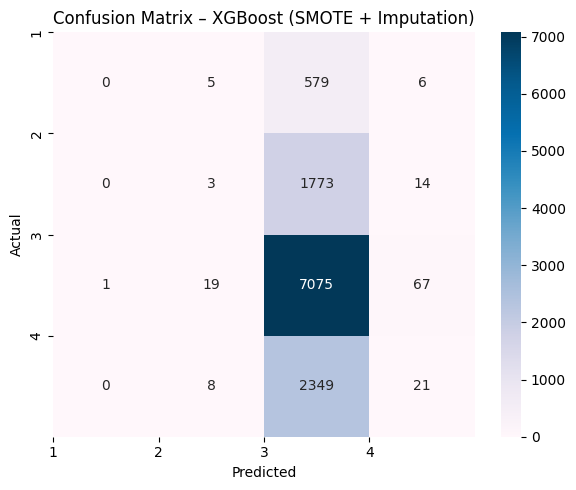

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Defining Features and Target
X = train_df_encoded.drop(columns=['Performance Rating'])
y = train_df_encoded['Performance Rating'] - 1  # XGBoost needs 0-based labels

# Train-Test Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Imputing missing values, important before SMOTE
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Applying SMOTE to the training data
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train_imputed, y_train)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test_imputed)

# Training the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_scaled, y_train_smote)

# Predict
y_pred = xgb_model.predict(X_test_scaled)

# Adjusting prediction back to original labels (1–4)
y_test_actual = y_test + 1
y_pred_actual = y_pred + 1

# Evaluate
print("Classification Report – XGBoost with SMOTE + Imputation")
print(classification_report(y_test_actual, y_pred_actual, zero_division=0))
print("Accuracy:", accuracy_score(y_test_actual, y_pred_actual))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test_actual, y_pred_actual), annot=True, fmt='d', cmap='PuBu')
plt.title("Confusion Matrix – XGBoost (SMOTE + Imputation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0, 1, 2, 3], labels=[1, 2, 3, 4])
plt.yticks(ticks=[0, 1, 2, 3], labels=[1, 2, 3, 4])
plt.tight_layout()
plt.show()


Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       590
           2       0.07      0.00      0.01      1790
           3       0.60      0.98      0.74      7162
           4       0.25      0.02      0.03      2378

    accuracy                           0.59     11920
   macro avg       0.23      0.25      0.20     11920
weighted avg       0.42      0.59      0.45     11920

Accuracy: 0.5912751677852349


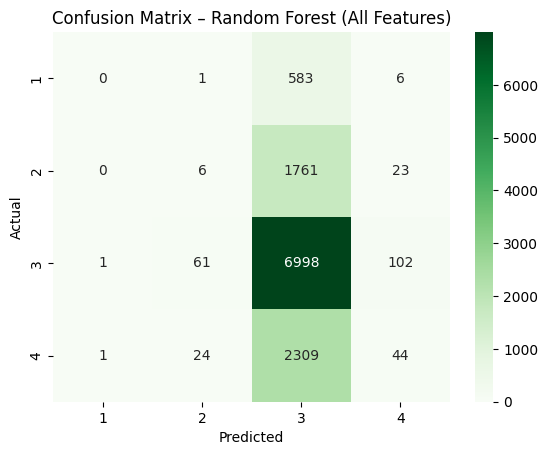

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Split X and y
X = train_df_encoded.drop(columns=["Performance Rating"])
y = train_df_encoded["Performance Rating"] - 1  # convert 1–4 → 0–3 for consistency

# Train-test split datasset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train = X_train.dropna()
y_train = y_train[X_train.index]

# Applying SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Training Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train_res)

# Predict and Evaluate
y_pred = rf_model.predict(X_test_scaled)
y_pred_actual = y_pred + 1
y_test_actual = y_test + 1

print("Classification Report:\n", classification_report(y_test_actual, y_pred_actual))
print("Accuracy:", accuracy_score(y_test_actual, y_pred_actual))

# Confusion Matrix
labels = sorted(np.unique(y_test_actual))
sns.heatmap(confusion_matrix(y_test_actual, y_pred_actual), annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix – Random Forest (All Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
#plt.xticks(ticks=[0, 1, 2, 3], labels=[1, 2, 3, 4])
#plt.yticks(ticks=[0, 1, 2, 3], labels=[1, 2, 3, 4])
plt.show()


<ipython-input-3-7350394e509a>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, y='Feature', x='Importance', palette='viridis')
<ipython-input-3-7350394e509a>:18: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


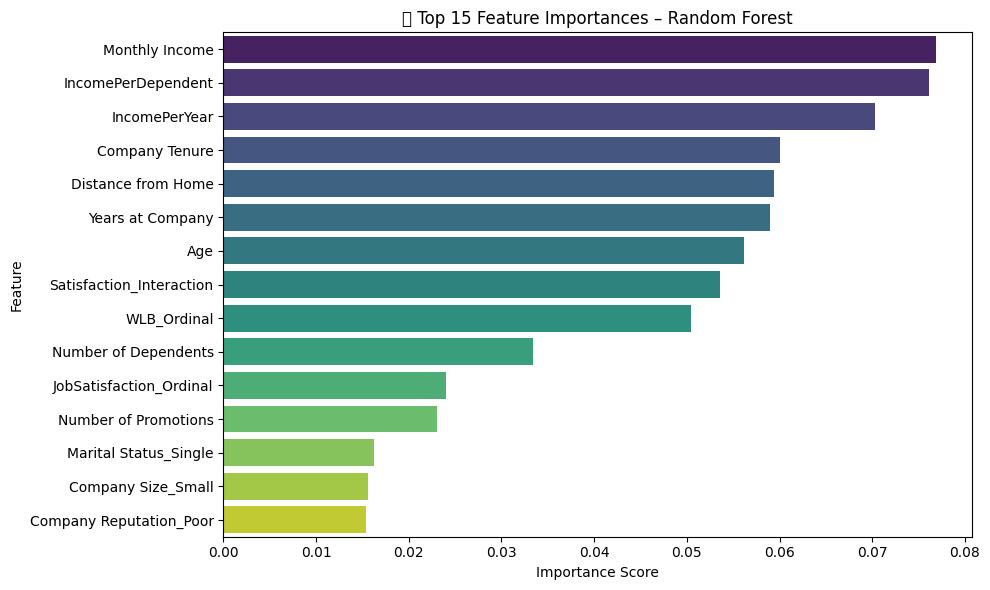

In [ ]:
# Feature Importance
import pandas as pd

# Getting feature names and importances
feature_names = X.columns
importances = rf_model.feature_importances_

# Creating DataFrame
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(15)  # Top 15

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df, y='Feature', x='Importance', palette='viridis')
plt.title("🔍 Top 15 Feature Importances – Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


📊 Classification Report – Ordinal Regression
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       590
           2       0.16      0.51      0.24      1790
           3       0.62      0.54      0.57      7162
           4       0.00      0.00      0.00      2378

    accuracy                           0.40     11920
   macro avg       0.19      0.26      0.20     11920
weighted avg       0.39      0.40      0.38     11920

Accuracy: 0.3985738255033557


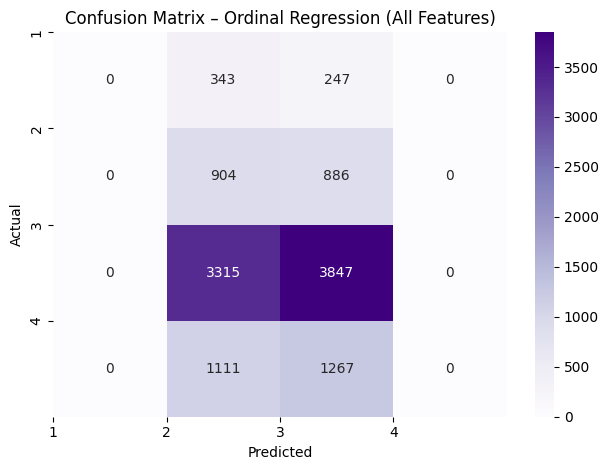

In [ ]:
from mord import OrdinalRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Splitting X and y
X = train_df_encoded.drop(columns=["Performance Rating"])
y = train_df_encoded["Performance Rating"]  # Keep as 1–4

# Imputing missing values before SMOTE
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Train-test split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

# Training Ordinal Regression
model = OrdinalRidge()
model.fit(X_train_scaled, y_train_sm)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)

print("Classification Report – Ordinal Regression")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix – Ordinal Regression (All Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0, 1, 2, 3], labels=[1, 2, 3, 4])
plt.yticks(ticks=[0, 1, 2, 3], labels=[1, 2, 3, 4])
plt.tight_layout()
plt.show()


In [ ]:
pip install statsmodels


Classification Report – Random Forest (Multivariate)
              precision    recall  f1-score   support

           1       0.05      0.16      0.08       487
           2       0.15      0.22      0.18      1477
           3       0.60      0.39      0.47      5788
           4       0.20      0.24      0.22      1953

    accuracy                           0.32      9705
   macro avg       0.25      0.25      0.24      9705
weighted avg       0.42      0.32      0.36      9705

Accuracy: 0.3224111282843895


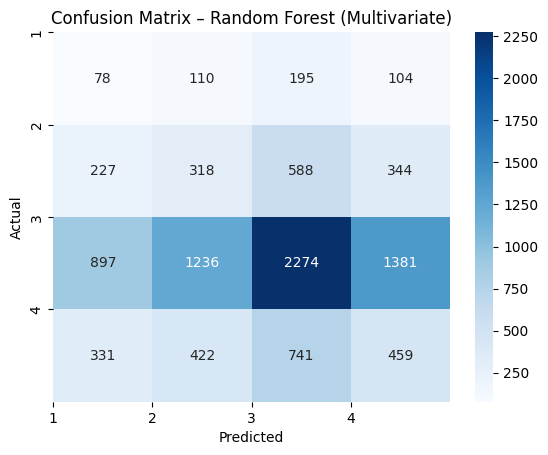

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Splitting features and target
X = train_df_encoded[['JobSatisfaction_Ordinal', 'WLB_Composite', 'IncomePerYear', 'Overtime_and_Remote']]  # custom selection
y = train_df_encoded["Performance Rating"] - 1  # convert 1–4 → 0–3

# Train-Test Split on dataset - 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Dropping missing values
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

# Applying SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Training Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train_resampled)

# Predict & Evaluate
y_pred = rf_model.predict(X_test_scaled)
y_test_actual = y_test + 1
y_pred_actual = y_pred + 1

print("Classification Report – Random Forest (Multivariate)")
print(classification_report(y_test_actual, y_pred_actual))
print("Accuracy:", accuracy_score(y_test_actual, y_pred_actual))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_actual, y_pred_actual), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Random Forest (Multivariate)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0,1,2,3], labels=[1,2,3,4])
plt.yticks(ticks=[0,1,2,3], labels=[1,2,3,4])
plt.show()
